# Analyzing Street Trees: Diversity Indices and the 10/20/30 Rule

This notebook analyzes the diversity indices of the street trees inside and outside the city center you've selected, and then check the tree inventory according to the 10/20/30 rule, discussed below.

In [44]:
# library import
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import treeParsing as tP

# Import Tree Inventory and City Center Boundary

Import your tree data and city center boundary data below. These data may use any geospatial data format (SHP, Geojson, Geopackage) and should be in the same coordinate projection.

Your tree data will need the following columns:
* Point geographic location
* Diameter at breast height (DBH)
* Tree Scientific Name
* Tree Genus Name
* Tree Family Name

Your city center geography simply needs to be a single, dissolved geometry representing your city center area.

In [45]:
### Enter the path to your data below ###
tree_data_path = 'example_data/trees_paris.gpkg'
tree_data = gpd.read_file(tree_data_path)

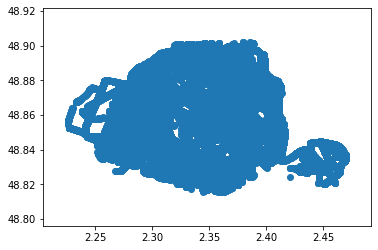

In [46]:
tree_data.plot()

In [47]:
### Enter the path to your data below ###
city_center_boundary_path = 'example_data/paris.gpkg'
city_center = gpd.read_file(city_center_boundary_path)

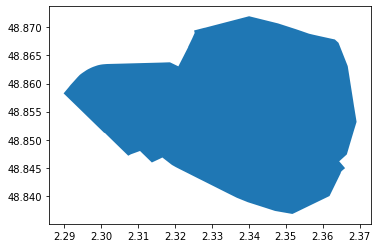

In [48]:
city_center.plot()

# Clean Data and Calculate Basal Area

To start, we need to remove features missing data and remove the top quantile of data. Removing any missing data and the top quantile helps remove erroneous entries that are too large or too small than what we would expect. If your data has already been cleaned, feel free to skip the second cell below.

In [49]:
### Enter your column names here ###
scientific_name_column = 'Scientific'
genus_name_column = 'genus'
family_name_column = 'family'
diameter_breast_height_column = 'DBH'

In [50]:
### Ignore if data is already cleaned ###
# Exclude Data Missing DBH
tree_data = tree_data[tree_data[diameter_breast_height_column]>0]

# Exclude data larger than the 99th quantile (often erroneously large)
tree_data = tree_data[tree_data[diameter_breast_height_column]<=tree_data.quantile(0.99).DBH]

In [51]:
# Calculate Basal Area
basal_area_column =  'BA'
tree_data[basal_area_column] = tree_data[diameter_breast_height_column]**2 * 0.00007854

# Calculating Simpson and Shannon Diversity Indices

The following cells spatially join your city center geometry to your tree inventory data, and then calculates the simpson and shannon diversity indices for the city center, area outside the city center -- based on area and tree count.

In [97]:
# Add dummy column to city center geometry
city_center['inside'] = True
city_center = city_center[['geometry','inside']]

In [98]:
# Spatial Join -- this may take a while
sjoin_tree_data = gpd.sjoin(tree_data, city_center, how="left")

In [54]:
def GenerateIndices(label, df, scientific_name_column, genus_name_column, family_name_column, basal_area_column):
    # Derive counts, areas, for species, genus, and family
    species_count = df[[scientific_name_column, basal_area_column]].groupby(scientific_name_column).count().reset_index()
    species_area = df[[scientific_name_column, basal_area_column]].groupby(scientific_name_column).sum().reset_index()

    genus_count = df[[genus_name_column, basal_area_column]].groupby(genus_name_column).count().reset_index()
    genus_area = df[[genus_name_column, basal_area_column]].groupby(genus_name_column).sum().reset_index()

    family_count = df[[family_name_column, basal_area_column]].groupby(family_name_column).count().reset_index()
    family_area = df[[family_name_column, basal_area_column]].groupby(family_name_column).sum().reset_index()


    # Calculate Percentages by count and area
    species_count["Pct"] = species_count[basal_area_column]/sum(species_count[basal_area_column])
    species_area["Pct"]  = species_area[basal_area_column]/sum(species_area[basal_area_column])

    genus_count["Pct"] = genus_count[basal_area_column]/sum(genus_count[basal_area_column])
    genus_area["Pct"] = genus_area[basal_area_column]/sum(genus_area[basal_area_column])

    family_count["Pct"] = family_count[basal_area_column]/sum(family_count[basal_area_column])
    family_area["Pct"] = family_area[basal_area_column]/sum(family_area[basal_area_column])

    # Calculate Shannon Indices
    species_shannon_count = tP.ShannonEntropy(list(species_count["Pct"]))
    species_shannon_area = tP.ShannonEntropy(list(species_area["Pct"]))

    genus_shannon_count = tP.ShannonEntropy(list(genus_count["Pct"]))
    genus_shannon_area = tP.ShannonEntropy(list(genus_area["Pct"]))

    family_shannon_count = tP.ShannonEntropy(list(family_count["Pct"]))
    family_shannon_area = tP.ShannonEntropy(list(family_area["Pct"]))

    # Calculate Simpson Indices
    species_simpson_count = tP.simpson_di(list(species_count[scientific_name_column]), list(species_count[basal_area_column]))
    species_simpson_area = tP.simpson_di(list(species_area[scientific_name_column]),list(species_area[basal_area_column]))

    genus_simpson_count = tP.simpson_di(list(genus_count[genus_name_column]), list(genus_count[basal_area_column]))
    genus_simpson_area = tP.simpson_di(list(genus_area[genus_name_column]), list(genus_area[basal_area_column]))

    family_simpson_count = tP.simpson_di(list(family_count[family_name_column]), list(family_count[basal_area_column]))
    family_simpson_area = tP.simpson_di(list(family_area[family_name_column]), list(family_area[basal_area_column]))

    return {
            'Geography':label,
            'species_simpson_count': species_simpson_count,
            'species_simpson_area': species_simpson_area,
            'genus_simpson_count': genus_simpson_count,
            'genus_simpson_area': genus_simpson_area,
            'family_simpson_count': family_simpson_count,
            'family_simpson_area': family_simpson_area,
            'species_shannon_count': species_shannon_count,
            'species_shannon_area': species_shannon_area,
            'genus_shannon_count': genus_shannon_count,
            'genus_shannon_area': genus_shannon_area,
            'family_shannon_count': family_shannon_count,
            'family_shannon_area': family_shannon_area
        }

In [55]:
# Generate results and load into dataframe
temp_results = []

city_center_data = sjoin_tree_data[sjoin_tree_data.inside == True]
outside_center_data = sjoin_tree_data[sjoin_tree_data.inside != True]

temp_results.append(
    GenerateIndices(
    'Inside City Center', 
    city_center_data,
    scientific_name_column, 
    genus_name_column, 
    family_name_column, 
    basal_area_column
    )
)


temp_results.append(
    GenerateIndices(
    'Outside City Center', 
    outside_center_data,
    scientific_name_column, 
    genus_name_column, 
    family_name_column, 
    basal_area_column
    )
)

results = pd.DataFrame(temp_results)
results.head()

,Geography,species_simpson_count,species_simpson_area,genus_simpson_count,genus_simpson_area,family_simpson_count,family_simpson_area,species_shannon_count,species_shannon_area,genus_shannon_count,genus_shannon_area,family_shannon_count,family_shannon_area
0,Inside City Center,0.830921,0.789103,0.695626,0.605508,0.689964,0.603462,2.625553,2.267669,1.939313,1.570327,1.788987,1.504692
1,Outside City Center,0.887075,0.795369,0.850146,0.749201,0.821799,0.730654,3.135827,2.459517,2.490724,1.947589,2.115954,1.738513


In [80]:
# Split up results for plotting
shannon_area = results.round(4)[['species_shannon_area','genus_shannon_area','family_shannon_area']].values
shannon_count = results.round(4)[['species_shannon_count','genus_shannon_count','family_shannon_count']].values
simpson_area = results.round(4)[['species_simpson_area','genus_simpson_area','family_simpson_area']].values
simpson_count = results.round(4)[['species_simpson_count','genus_simpson_count','family_simpson_count']].values

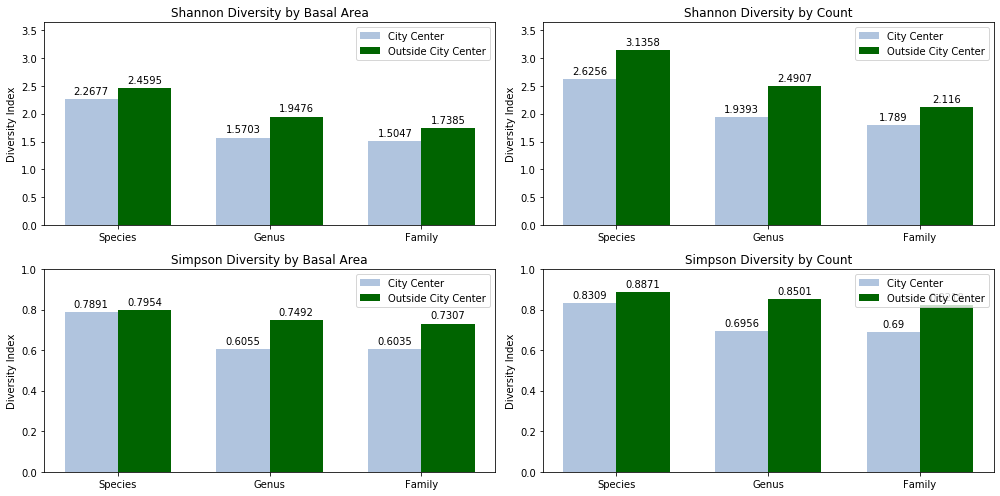

In [102]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
labels = ['Species', 'Genus', 'Family']
plt.rcParams["figure.figsize"] = [14, 7]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(2, 2)

rects1 = [axs[0,0].bar(x - width/2, shannon_area[0], width, color="lightsteelblue", label='City Center'), axs[0,0].bar(x + width/2, shannon_area[1], width, color="darkgreen", label='Outside City Center')]
rects2 = [axs[0,1].bar(x - width/2, shannon_count[0], width, color="lightsteelblue", label='City Center'), axs[0,1].bar(x + width/2, shannon_count[1], width, color="darkgreen", label='Outside City Center')]
rects3 = [axs[1,0].bar(x - width/2, simpson_area[0], width, color="lightsteelblue", label='City Center'), axs[1,0].bar(x + width/2, simpson_area[1], width, color="darkgreen", label='Outside City Center')]
rects4 = [axs[1,1].bar(x - width/2, simpson_count[0], width, color="lightsteelblue", label='City Center'), axs[1,1].bar(x + width/2, simpson_count[1], width, color="darkgreen", label='Outside City Center')]

axs[0,0].set_ylabel('Diversity Index')
axs[0,0].set_title('Shannon Diversity by Basal Area')
axs[0,0].set_xticks(x)
axs[0,0].set_xticklabels(labels)
axs[0,0].legend()

axs[0,1].set_ylabel('Diversity Index')
axs[0,1].set_title('Shannon Diversity by Count')
axs[0,1].set_xticks(x)
axs[0,1].set_xticklabels(labels)
axs[0,1].legend()

axs[1,0].set_ylabel('Diversity Index')
axs[1,0].set_title('Simpson Diversity by Basal Area')
axs[1,0].set_xticks(x)
axs[1,0].set_xticklabels(labels)
axs[1,0].legend()

axs[1,1].set_ylabel('Diversity Index')
axs[1,1].set_title('Simpson Diversity by Count')
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(labels)
axs[1,1].legend()

autolabel(rects1[0], axs[0,0])
autolabel(rects1[1], axs[0,0])
autolabel(rects2[0], axs[0,1])
autolabel(rects2[1], axs[0,1])
autolabel(rects3[0], axs[1,0])
autolabel(rects3[1], axs[1,0])
autolabel(rects4[0], axs[1,1])
autolabel(rects4[1], axs[1,1])


axs[0,0].set_ylim([0,max(shannon_count.max(), shannon_area.max())+0.5])
axs[0,1].set_ylim([0,max(shannon_count.max(), shannon_area.max())+0.5])
axs[1,0].set_ylim([0,1])
axs[1,1].set_ylim([0,1])

fig.tight_layout()

plt.show()

# Interpreting these Results

For both indices, a higher score represents a more diverse body of street trees. If your city follows our general findings, the city center tends to be less diverse. The results provide some context on the evenness of the diversity in the city center and outside areas. The cells below calculate how well your street trees adhere to the 10/20/30 standard.

____
# 10/20/30 Standard

The 10/20/30 rule suggests that urban forests should be made up of no more than 10% from one species, 20% from one genus, or 30% from one family. A more optimistic version, the 5/10/15 rule, argues that those values should be halved. 

Below, we'll calculate how well your tree inventory data adheres to these rules and then chart the results.

In [132]:
def GetPctRule(df, column, basal_area_column, predicate, location):
    if predicate == 'area':
        tempData = df[[basal_area_column,column]].groupby(column).sum().sort_values(basal_area_column, ascending=False).reset_index()
    else:
        tempData = df[[basal_area_column,column]].groupby(column).count().sort_values(basal_area_column, ascending=False).reset_index()
    
    total = tempData[basal_area_column].sum()
    
    return {
        'name':column,
        'location': location,
        'predicate':predicate,
        'most common': tempData.iloc[0][column],
        'amount': tempData.iloc[0][basal_area_column],
        'percent': round(tempData.iloc[0][basal_area_column]/total*100,2),
        'total': total,
    }

In [134]:
temp_results = []

for location in ['City Center', 'Outside City Center']:
    for column in [scientific_name_column, genus_name_column, family_name_column]:
        for predicate in ['area', 'count']:
            if location == 'City Center':
                df = city_center_data
            else:
                df = outside_center_data
            temp_results.append(GetPctRule(df, column, basal_area_column, predicate, location))
            
results = pd.DataFrame(temp_results)
results.head()

,name,location,predicate,most common,amount,percent,total
0,Scientific,City Center,area,Platanus Hispanica,405.118253,39.83,1017.000658
1,Scientific,City Center,count,Platanus Hispanica,4699.000000,35.94,13074.000000
2,genus,City Center,area,Platanus,618.680725,60.86,1016.540898
3,genus,City Center,count,Platanus,6853.000000,52.45,13065.000000
4,family,City Center,area,Platanaceae,618.680725,60.86,1016.540898


In [193]:
results[results.name=='Scientific']

,name,location,predicate,most common,amount,percent,total
0,Scientific,City Center,area,Platanus Hispanica,405.118253,39.83,1017.000658
1,Scientific,City Center,count,Platanus Hispanica,4699.000000,35.94,13074.000000
6,Scientific,Outside City Center,area,Platanus Hispanica,2716.026453,40.07,6778.510383
7,Scientific,Outside City Center,count,Platanus Hispanica,25356.000000,28.25,89755.000000


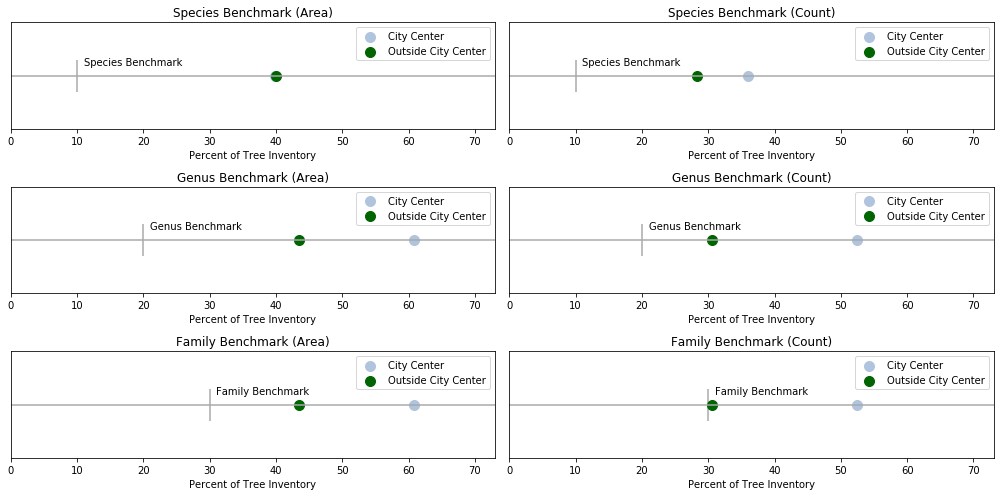

In [209]:
fig, axs = plt.subplots(3,2)

columns = [scientific_name_column, genus_name_column, family_name_column]
predicates=['area', 'count']
max_value = results.percent.max() * 1.2

for row in [0,1,2]:
    temp_data = results[results.name==columns[row]]
    for col in [0,1]:
        temp_col_data = temp_data[temp_data.predicate==predicates[col]]
        if row == 0:
            x_value = 10
            text="Species Benchmark"
        elif row == 1:
            x_value = 20
            text="Genus Benchmark"
        else:
            x_value = 30
            text="Family Benchmark"
         
        if col == 0:
            title = text + ' (Area)'
        else:
            title = text + ' (Count)'
            
        axs[row,col].set_xlabel('Percent of Tree Inventory')
        axs[row,col].set_xlim([0,max_value])
        axs[row,col].set_ylim([-0.1,0.1])
        axs[row,col].get_yaxis().set_visible(False)
        axs[row,col].plot([0,max_value], [0,0], c='darkgray')
        axs[row,col].scatter(x=x_value, y=0, marker='|', s=1000, c='darkgray')
        axs[row,col].text(x=x_value+1, y=0.02, linespacing=2, s=text, c='black')
        axs[row,col].set_title(title)
        axs[row,col].scatter(x=float(temp_col_data[temp_col_data.location=='City Center'].percent), y=0, s=100, c='lightsteelblue', label='City Center')
        axs[row,col].scatter(x=float(temp_col_data[temp_col_data.location=='Outside City Center'].percent), y=0, s=100, c='darkgreen', label='Outside City Center')
        axs[row,col].legend()
plt.tight_layout()
plt.show()

# Interpreting these Results

The closer the green dots are to the vertical benchmark line, the closer the tree inventory is to meeting the benchmark. Ideally, each dot should be at or to the left of that taxonomy level's benchmark (10, 20, or 30%). The charts on the left reflect tree species diversity by area, which may better reflect the street trees scaled to their mass, and the right column tracks the count of trees, which is more widely used in urban forestry. 

These charts do not define the success of the street tree inventory you are exploring, but they do highlight whether or not the data adheres to suggested urban forestry standards.
___

Want to share you results? Contact us at ***senseable-trees@mit.edu***, we'd love to hear how you used this notebook!